# **IMPORTS**

**IMPORTS**

In [ ]:
!pip install emoji
!pip install pyspellchecker
!pip install -q transformers
!pip install glove-python3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.0/327.0 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for glove-python3: filename=glove_python3-0.1.0-cp310-cp310-linux_x86_64.whl size=1065512 sha256=3346fdabd2c1a623304ea8382e843fbff4bb43562e6768158c7d0788a95997cb
  Stored in directory: /root/.cache/pip/wheels/fe/2f/79/34314d44a0907e90e323c8c182ec23f126eb460829e02d98cf
Successfully built glove-python3


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [109]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.cuda
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

import urllib

import csv

from transformers import RobertaTokenizer

from glove import Glove,Corpus

torch.manual_seed(1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
import re
import string
import emoji

from spellchecker import SpellChecker
spell = SpellChecker()

import nltk
from nltk.corpus import stopwords


In [ ]:
nltk.download("punkt")
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Exploratory Data Analysis**

In [ ]:
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/mapping.txt"

train_text_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/train_text.txt"
train_labels_id_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/train_labels.txt"

test_labels_id_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/test_labels.txt"
test_text_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/test_text.txt"

val_labels_id_link=f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/val_labels.txt"
val_text_link=f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/val_text.txt"




**Helper functions**

In [ ]:

def map_id_to_label(id):
  try:
    id_int = int(id)
    return labels[id_int]
  except ValueError:
    return "Invalid ID"
  except KeyError:
    return "ID not found"

In [ ]:
def createDataFrame(text_link, label_link):
  #create train dataframe
  df=pd.DataFrame()

  with urllib.request.urlopen(text_link) as f:
      text = f.read().decode('utf-8').split("\n")
      df["Tweet"] = text

  with urllib.request.urlopen(label_link) as f:
      label_id = f.read().decode('utf-8').split("\n")
      df["label_id"] = label_id

  #map coresponding id to the a label and append it to the dataframe
  df["label"] = df["label_id"].apply(map_id_to_label)
  df['tweet_length'] = df['Tweet'].apply(len)
  #remove last row because it does not contain any data
  df = df.drop(df.index[-1])
  return df

Create Dataframes

In [ ]:
#Load emotion labels

with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')

labels = [row[1] for row in csvreader if len(row) > 1]
labels

['anger', 'joy', 'optimism', 'sadness']

In [ ]:

#create train dataframe
df_train=createDataFrame(train_text_link,train_labels_id_link)

#create train dataframe
df_test=createDataFrame(test_text_link,test_labels_id_link)

#create train dataframe
df_val=createDataFrame(val_text_link,val_labels_id_link)



**Train DataFrame Analysis**

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3257 entries, 0 to 3256
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Tweet         3257 non-null   object
 1   label_id      3257 non-null   object
 2   label         3257 non-null   object
 3   tweet_length  3257 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 101.9+ KB


In [ ]:
df_train.head()

,Tweet,label_id,label,tweet_length
0,“Worry is a down payment on a problem you may ...,2,optimism,105
1,My roommate: it's okay that we can't spell bec...,0,anger,99
2,No but that's so cute. Atsu was probably shy a...,1,joy,95
3,Rooneys fucking untouchable isn't he? Been fuc...,0,anger,103
4,it's pretty depressing when u hit pan on ur fa...,3,sadness,66


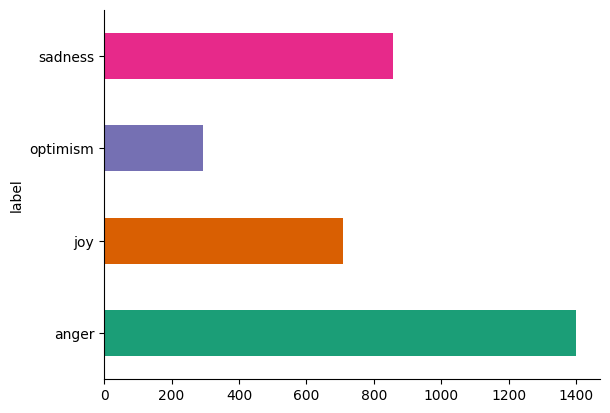

In [ ]:
df_train.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

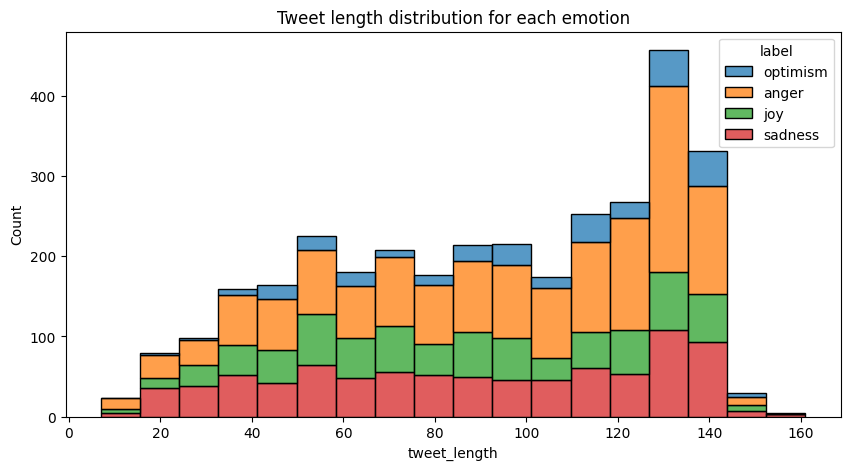

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(df_train, x="tweet_length", hue="label", multiple="stack")
plt.title('Tweet length distribution for each emotion')
plt.show()


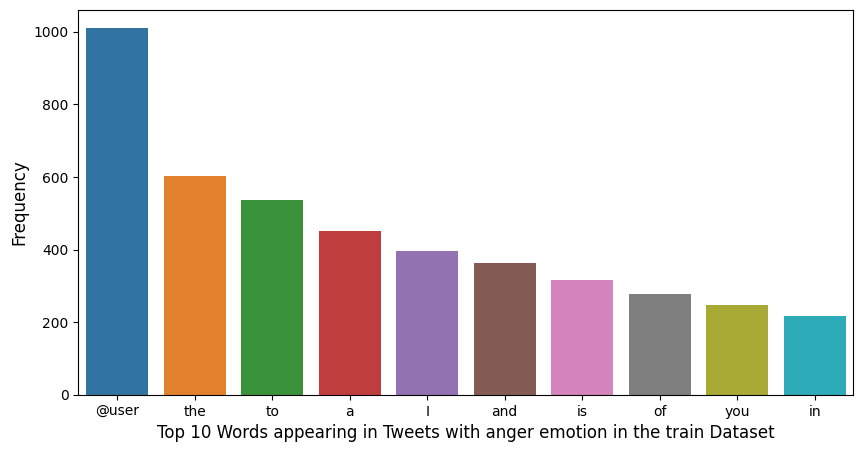

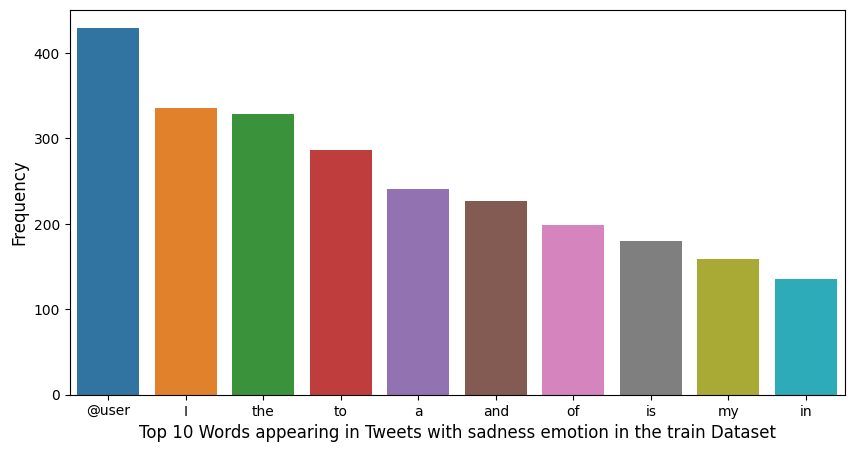

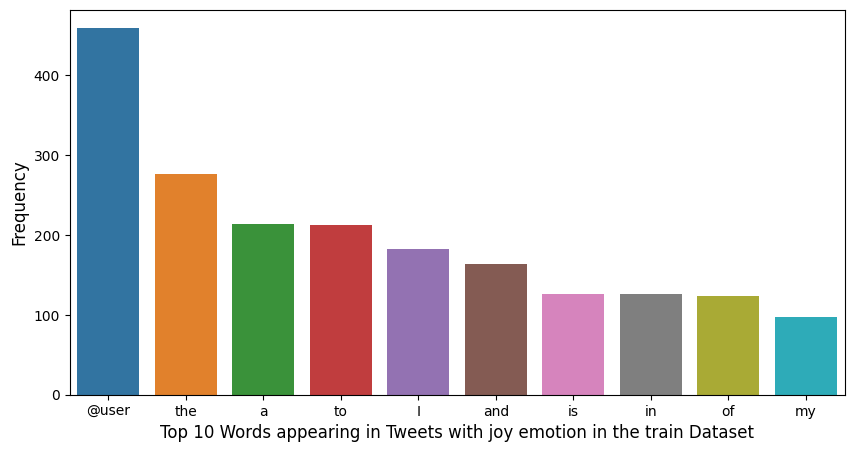

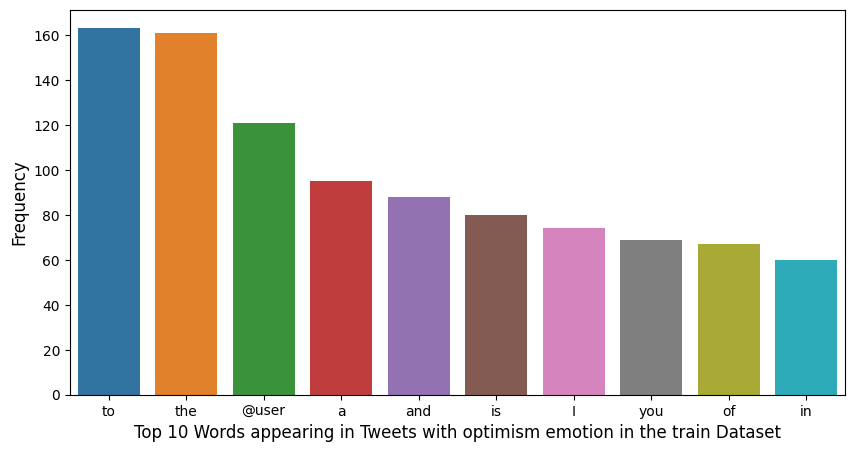

In [ ]:
#Plotting the bar graph of top frequently 10 occuring words for each Emotion in train Dataset
data=df_train.label.value_counts()

for i in range(0,4):
      Emotion = df_train[df_train['label'] == data.index[i]]#Creating the dataframe of having same sentiment
      Word_frequency = pd.Series(' '.join(Emotion['Tweet']).split()).value_counts()[:10]#Calculating the words frequency
      plt.figure(figsize=(10,5))
      sns.barplot(x=Word_frequency.index, y=Word_frequency.values, )
      plt.ylabel('Frequency', fontsize=12)
      plt.xlabel('Top 10 Words appearing in Tweets with '+str(data.index[i])+' emotion in the train Dataset', fontsize=12)
      plt.show()

In [ ]:
# Group by labels and describe tweets statistics
# Some tweets are found multiple times in the dataset
print(df_train.groupby('label')['Tweet'].describe())

         count unique                                                top freq
label                                                                        
anger     1400   1400  My roommate: it's okay that we can't spell bec...    1
joy        708    683  Watch this amazing live.ly broadcast by @user ...   15
optimism   294    294  “Worry is a down payment on a problem you may ...    1
sadness    855    855  it's pretty depressing when u hit pan on ur fa...    1


**Test DataFrame Analysis**

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421 entries, 0 to 1420
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Tweet         1421 non-null   object
 1   label_id      1421 non-null   object
 2   label         1421 non-null   object
 3   tweet_length  1421 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 44.5+ KB


In [ ]:
df_test.head()

,Tweet,label_id,label,tweet_length
0,#Deppression is real. Partners w/ #depressed p...,3,sadness,145
1,@user Interesting choice of words... Are you c...,0,anger,124
2,My visit to hospital for care triggered #traum...,3,sadness,141
3,@user Welcome to #MPSVT! We are delighted to h...,1,joy,87
4,What makes you feel #joyful?,1,joy,29


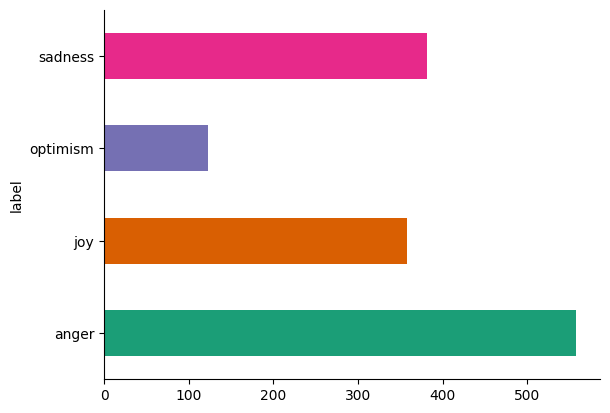

In [ ]:
df_test.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Group by labels and describe tweets statistics
print(df_test.groupby('label')['Tweet'].describe())

         count unique                                                top freq
label                                                                        
anger      558    558  @user Interesting choice of words... Are you c...    1
joy        358    358  @user Welcome to #MPSVT! We are delighted to h...    1
optimism   123    123  @user @user Americans do not spank their child...    1
sadness    382    382  #Deppression is real. Partners w/ #depressed p...    1


**Validation DataFrame Analysis**

In [ ]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Tweet         374 non-null    object
 1   label_id      374 non-null    object
 2   label         374 non-null    object
 3   tweet_length  374 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 11.8+ KB


In [ ]:
df_val.head()

,Tweet,label_id,label,tweet_length
0,"@user @user Oh, hidden revenge and anger...I r...",0,anger,80
1,if not then #teamchristine bc all tana has don...,0,anger,136
2,Hey @user #Fields in #skibbereen give your onl...,0,anger,130
3,Why have #Emmerdale had to rob #robron of havi...,0,anger,120
4,@user I would like to hear a podcast of you go...,0,anger,109


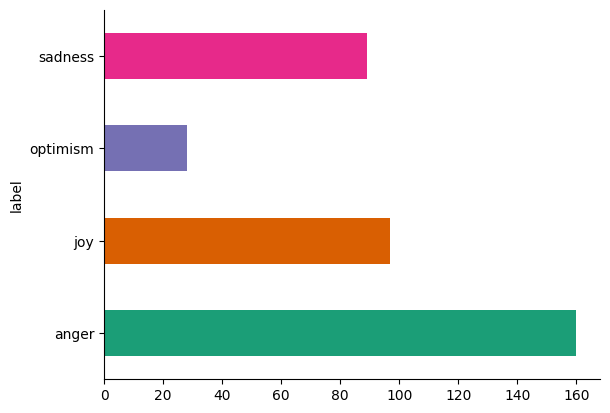

In [ ]:
df_val.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Group by labels and describe tweets statistics
print(df_val.groupby('label')['Tweet'].describe())

         count unique                                                top freq
label                                                                        
anger      160    160  @user @user Oh, hidden revenge and anger...I r...    1
joy         97     97  @user Too much fun being interviewed by the su...    1
optimism    28     28  You can have a certain #arrogance, and I think...    1
sadness     89     89                                 depression sucks😔     1


# **Preprocessing**

In [ ]:
abbreviations = {
    "w/": "with",
    "w/o": "without",
    "msg": "message",
    "u": "you",
    "r": "are",
    "lol": "laughing out loud",
    "np": "no problem",
    "LOL": "laughing out loud",
    "XD" : "laugh",
    "xd" : "laugh"
}

# Define a function to correct abbreviations in a string
def correct_abbreviations(text, abbreviations):
    words = text.split()
    corrected_words = []
    for word in words:
        if word in abbreviations:
            corrected_word = abbreviations[word]
            corrected_words.append(corrected_word)
        else:
            corrected_words.append(word)
    corrected_text = ' '.join(corrected_words)
    return corrected_text

In [ ]:
# Define a function to correct spelling mistakes in a string
def correct_spelling(text):
    words = text.split()
    corrected_words = []
    for word in words:
        corrected_word = spell.correction(word)
        if corrected_word != None:
          corrected_words.append(corrected_word)
        # print(corrected_word)
    corrected_text = ' '.join(corrected_words)
    return corrected_text

In [ ]:
def preprocess_tweet(tweet):
  # Convert all words to lower case
  tweet = tweet.lower()

  # Removing HTML Tags, URLs and Website Links
  # Removing Website Links
  temp_text = tweet.split()

  for i in temp_text:
    if i[-4:] == ".com" or i[:4] == "www.":
      temp_text.remove(i)

  tweet = ' '.join(temp_text)

  # Remove HTML tags
  clean_text = re.sub('<[^<]+?>', '', tweet)

  # Remove URLs
  clean_text = re.sub(r'http\S+', '', clean_text)

  tweet = clean_text

  # Remove numbers
  tweet = re.sub(r'\d+', '', tweet)

  # Deemojize Emojis
  tweet = emoji.demojize(tweet)

  # Correct Abbreviations
  tweet = correct_abbreviations(tweet, abbreviations)

  # Remove mentions
  tweet = re.sub(r'@user', '', tweet)


  # Remove all stop words
  # Tokenize the sentence
  tokens = nltk.word_tokenize(tweet)
  # Remove stop words
  clean_tokens = [token for token in tokens if not token.lower() in stop_words]
  # Join the tokens back into a sentence
  tweet = ' '.join(clean_tokens)

  # Remove all punctuations
  tweet = tweet.translate(str.maketrans('', '', string.punctuation))

  # Spellcheck
  try:
    tweet = correct_spelling(tweet)
  except Exception as e:
    print(e)


  return tweet

**Preprocess the tweets**

In [ ]:
df_train["Preprocessed Tweet"] = df_train["Tweet"].apply(preprocess_tweet)



In [ ]:
df_test["Preprocessed Tweet"] = df_test["Tweet"].apply(preprocess_tweet)



In [ ]:
df_val["Preprocessed Tweet"] = df_val["Tweet"].apply(preprocess_tweet)

In [ ]:
cols = list(df_train.columns.values)
cols

['Tweet', 'label_id', 'label', 'Preprocessed Tweet']

In [ ]:
df_train = df_train[['Tweet', 'Preprocessed Tweet', 'label_id','label']]

df_test = df_test[['Tweet', 'Preprocessed Tweet', 'label_id','label']]

df_val = df_val[['Tweet', 'Preprocessed Tweet', 'label_id','label']]

df_train.head()

,Tweet,Preprocessed Tweet,label_id,label
0,“Worry is a down payment on a problem you may ...,i worry payment problem may never joyce meyer ...,2,optimism
1,My roommate: it's okay that we can't spell bec...,roommate i okay ca it spell terrible,0,anger
2,No but that's so cute. Atsu was probably shy a...,i cute asu probably shy photos cherry helped wu,1,joy
3,Rooneys fucking untouchable isn't he? Been fuc...,honeys fucking untouchable it fucking dreadful...,0,anger
4,it's pretty depressing when u hit pan on ur fa...,i pretty depressing hit pan ur favourite highl...,3,sadness


In [ ]:
df_train.to_csv('train_dataframe.csv')
df_test.to_csv('test_dataframe.csv' )
df_val.to_csv('val_dataframe.csv')

# **LOAD DATA**

In [134]:
df_train = pd.read_csv('train_dataframe.csv')
df_test = pd.read_csv('test_dataframe.csv')
df_val = pd.read_csv('val_dataframe.csv')


**Filter datasets**

In [ ]:
dataset_filter_1 = ["anger", "joy"]

dataset_filter_2 = ["anger", "sadness"]


df_1_train = df_train[df_train['label'].isin(dataset_filter_1)]
df_1_test = df_train[df_train['label'].isin(dataset_filter_1)]
df_1_val = df_train[df_train['label'].isin(dataset_filter_1)]


df_2_train = df_train[df_train['label'].isin(dataset_filter_2)]
df_2_test = df_train[df_train['label'].isin(dataset_filter_2)]
df_2_val = df_train[df_train['label'].isin(dataset_filter_2)]




In [ ]:
# Create dataset from dataframe
class GloveDataset(Dataset):
  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    text =self.df.iloc[idx]['Preprocessed Tweet']
    return text

In [129]:


dataset = GloveDataset(df_train)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=64,shuffle=True)

# Create Corpus
corpus = Corpus()
# Create Glove model
glove_model = Glove()

for batch in dataloader:
  tokenized = []

  for text in batch:
    words = re.split(r"\s+", text)
    tokenized.append(words)

  #training the corpus to generate the co occurence matrix which is used in GloVe
  corpus.fit(tokenized, window=10)


print(len(corpus.dictionary))


6828


In [123]:
glove = Glove(no_components=5, learning_rate=0.05)
glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)
glove.save('glove.model')

Performing 30 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [133]:
model = Glove.load("glove.model")
model.word_vectors[model.dictionary['world']]

array([ 0.00146143, -0.01669093, -0.00032372,  0.03706503,  0.00155377])

In [132]:
# Word tokenizer
from nltk.tokenize import word_tokenize

class TweetDataset(Dataset):

  def __init__(self, tweets, labels):
    self.tweets = tweets
    self.labels = labels

  def __len__(self):
    return len(self.tweets)

  def __getitem__(self, index):
    tweet = self.tweets[index]
    label = self.labels[index]

    transformed_tweet = self.transform_tweet(tweet)



    return {

      "input_vector": transformed_tweet,
      'label': torch.tensor(label)
    }

  def transform_tweet(self, tweet):

    # Tokenize tweet
    tokens = word_tokenize(tweet)

    # Vectorize tokens
    vector = [model.word_vectors[model.dictionary[token]] for token in tokens]

    # Pad/truncate to max length
    max_length = 128
    vector = vector[:max_length]
    vector += [0] * (max_length - len(vector))

    # Convert to tensor
    vector = torch.tensor(vector, dtype=torch.long)
    return vector

In [ ]:
#Loading the model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-emotion"
tokenizer = RobertaTokenizer.from_pretrained(model_name)

tweet="finally started story gameplay terrible"

inputs = tokenizer(tweet, truncation=True, padding='max_length', max_length=64)
inputs

{'input_ids': [0, 506, 30672, 554, 527, 23841, 6587, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}